In [1]:
from operator import itemgetter
import numpy as np
import pydicom
from time import time
import traceback

import sqlite3
from sqlite3 import Error

from LazyLuna.Tables import Table
from LazyLuna.Views import *
from LazyLuna.loading_functions import *
from LazyLuna.Mini_LL import *
from LazyLuna import utils

In [2]:

class SAX_slice_phase_Category:
    def __init__(self, case):
        self.case = case
        self.sop2depthandtime = self.get_sop2depthandtime(case.imgs_sop2filepath)
        self.depthandtime2sop = {v:k for k,v in self.sop2depthandtime.items()}
        self.set_nr_slices_phases()
        self.set_image_height_width_depth()

    # try a sort function as in dcmlabeling_1_tab
    def get_sop2depthandtime(self, sop2filepath, debug=True):
        if debug: st = time()
        imgs = {k:pydicom.dcmread(sop2filepath[k]) for k in sop2filepath.keys()} # stop_before_pixels=TRUE?
        
        sortable = [[k,v.SliceLocation,v.InstanceNumber] for k,v in imgs.items()]
        #sortable = [[k,float(v.SliceLocation),float(v.AcquisitionNumber)] for k,v in imgs.items()]
        slice_nrs = {x:i for i,x in enumerate(sorted(list(set([x[1] for x in sortable]))))}
        sortable = [s+[slice_nrs[s[1]]] for s in sortable]
        sortable_by_slice = {d:[] for d in slice_nrs.values()}
        for s in sortable: sortable_by_slice[s[-1]].append(s)
        for d in range(len(sortable_by_slice.keys())):
            sortable_by_slice[d] = sorted(sortable_by_slice[d], key=lambda s:s[2])
            for p in range(len(sortable_by_slice[d])):
                sortable_by_slice[d][p].append(p)
        sop2depthandtime = dict()
        for d in range(len(sortable_by_slice.keys())):
            for s in sortable_by_slice[d]:
                sop2depthandtime[s[0]] = (s[-2],s[-1])
        
        # potentially flip slice direction: base top x0<x1, y0>y1, z0>z1, apex top x0>x1, y0<y1, z0<z1
        depthandtime2sop = {v:k for k,v in sop2depthandtime.items()}
        img1, img2 = imgs[depthandtime2sop[(0,0)]], imgs[depthandtime2sop[(1,0)]]
        img1x,img1y,img1z = list(map(float,img1.ImagePositionPatient))
        img2x,img2y,img2z = list(map(float,img2.ImagePositionPatient))
        if img1x<img2x and img1y>img2y and img1z>img2z: pass
        else: #img1x>img2x or img1y<img2y or img1z<img2z:
            max_depth = max(sortable_by_slice.keys())
            for sop in sop2depthandtime.keys():
                sop2depthandtime[sop] = (max_depth-sop2depthandtime[sop][0], sop2depthandtime[sop][1])
        if debug: print('calculating sop2sorting takes: ', time()-st)
        return sop2depthandtime

    def set_image_height_width_depth(self, debug=False):
        if debug: st = time()
        nr_slices = self.nr_slices
        for slice_nr in range(nr_slices):
            sop = self.depthandtime2sop[(slice_nr, 0)]
            dcm = self.case.load_dcm(sop)
            self.height, self.width    = dcm.pixel_array.shape
            self.pixel_h, self.pixel_w = list(map(float, dcm.PixelSpacing))
            try: self.spacing_between_slices = dcm.SpacingBetweenSlices
            except Exception as e:
                self.spacing_between_slices = dcm.SliceThickness
                print('Exception in SAX_Slice_Phase_Category, ', e)
            try: self.slice_thickness = dcm.SliceThickness
            except Exception as e: print('Exception in SAX_Slice_Phase_Category, ', e)
        if debug: print('Setting stuff took: ', time()-st)

    def set_nr_slices_phases(self):
        dat = list(self.depthandtime2sop.keys())
        self.nr_phases = max(dat, key=itemgetter(1))[1]+1
        self.nr_slices = max(dat, key=itemgetter(0))[0]+1
        
    def get_dcm(self, slice_nr, phase_nr):
        sop = self.depthandtime2sop[(slice_nr, phase_nr)]
        return self.case.load_dcm(sop)

    def get_anno(self, slice_nr, phase_nr):
        try: sop = self.depthandtime2sop[(slice_nr, phase_nr)]
        except Exception as e:
            print(e)
            sop = None
        return self.case.load_anno(sop)

    def get_img(self, slice_nr, phase_nr, value_normalize=True, window_normalize=True):
        try:
            sop = self.depthandtime2sop[(slice_nr, phase_nr)]
            img = self.case.get_img(sop, value_normalize=value_normalize, window_normalize=window_normalize)
        except Exception as e:
            print(e)
            img = np.zeros((self.height, self.width))
        return img

    def get_imgs_phase(self, phase_nr, value_normalize=True, window_normalize=True):
        return [self.get_img(d, phase_nr, value_normalize, window_normalize) for d in range(self.nr_slices)]

    def get_annos_phase(self, phase):
        return [self.get_anno(d,phase) for d in range(self.nr_slices)]

    def get_volume(self, cont_name, phase):
        if np.isnan(phase): return 0.0
        annos = self.get_annos_phase(phase)
        pixel_area = self.pixel_h * self.pixel_w
        areas = [a.get_contour(cont_name).area*pixel_area if a is not None else 0.0 for a in annos]
        has_conts = [a!=0 for a in areas]
        if True not in has_conts: return 0
        base_idx, apex_idx  = has_conts.index(True), has_conts[::-1].index(True)
        vol = 0
        for d in range(self.nr_slices):
            pixel_depth = (self.spacing_between_slices + self.slice_thickness)/2.0 if d in [base_idx, apex_idx] else self.spacing_between_slices
            vol += areas[d] * pixel_depth
        return vol / 1000.0

    def get_volume_curve(self, cont_name):
        return [self.get_volume(cont_name, p) for p in range(self.nr_phases)]


In [27]:
class Organizer:
    def __init__(self, case):
        self.case = case
        self.sop2depthandtime = self.get_sop2depthandtime(case.imgs_sop2filepath)
        self.depthandtime2sop = {v:k for k,v in self.sop2depthandtime.items()}
        self.set_nr_slices_phases()
        self.set_image_height_width_depth()

    # try a sort function as in dcmlabeling_1_tab
    def get_sop2depthandtime(self, sop2filepath, debug=True):
        if debug: st = time()
        # returns dict sop --> (depth, time)
        imgs = {k:pydicom.dcmread(sop2filepath[k], stop_before_pixels=True) for k in sop2filepath.keys()} # stop_before_pixels=TRUE?
        
        sortable  = [[k,v.SliceLocation,v.InstanceNumber] for k,v in imgs.items()]
        slice_nrs = {x:i for i,x in enumerate(sorted(list(set([x[1] for x in sortable]))))}
        sortable  = [s+[slice_nrs[s[1]]] for s in sortable]
        sortable_by_slice = {d:[] for d in slice_nrs.values()}
        for s in sortable: sortable_by_slice[s[-1]].append(s)
        for d in range(len(sortable_by_slice.keys())):
            sortable_by_slice[d] = sorted(sortable_by_slice[d], key=lambda s:s[2])
            for p in range(len(sortable_by_slice[d])):
                sortable_by_slice[d][p].append(p)
        sop2depthandtime = dict()
        for d in range(len(sortable_by_slice.keys())):
            for s in sortable_by_slice[d]:
                sop2depthandtime[s[0]] = (s[-2],s[-1])
        #if debug: print('calculating sop2sorting takes: ', time()-st)
        
        # potentially flip slice direction: base top x0<x1, y0>y1, z0>z1, apex top x0>x1, y0<y1, z0<z1
        depthandtime2sop = {v:k for k,v in sop2depthandtime.items()}
        img1, img2 = imgs[depthandtime2sop[(0,0)]], imgs[depthandtime2sop[(1,0)]]
        img1x,img1y,img1z = list(map(float,img1.ImagePositionPatient))
        img2x,img2y,img2z = list(map(float,img2.ImagePositionPatient))
        if img1x<img2x and img1y>img2y and img1z>img2z: pass
        else: #img1x>img2x or img1y<img2y or img1z<img2z:
            max_depth = max(sortable_by_slice.keys())
            for sop in sop2depthandtime.keys():
                sop2depthandtime[sop] = (max_depth-sop2depthandtime[sop][0], sop2depthandtime[sop][1])
        if debug: print('calculating sop2sorting takes: ', time()-st)
        
        return sop2depthandtime

    def set_image_height_width_depth(self, debug=False):
        if debug: st = time()
        nr_slices = self.nr_slices
        for slice_nr in range(nr_slices):
            sop = self.depthandtime2sop[(slice_nr, 0)]
            dcm = self.case.load_dcm(sop)
            self.height, self.width    = dcm.pixel_array.shape
            self.pixel_h, self.pixel_w = list(map(float, dcm.PixelSpacing))
            try: self.spacing_between_slices = dcm.SpacingBetweenSlices
            except Exception as e:
                self.spacing_between_slices = dcm.SliceThickness
                print(traceback.print_exc())
            try: self.slice_thickness = dcm.SliceThickness
            except Exception as e: print(traceback.print_exc())
        if debug: print('Setting stuff took: ', time()-st)

    def set_nr_slices_phases(self):
        dat = list(self.depthandtime2sop.keys())
        self.nr_phases = max(dat, key=itemgetter(1))[1]+1
        self.nr_slices = max(dat, key=itemgetter(0))[0]+1
        
    def get_dcm(self, slice_nr, phase_nr):
        sop = self.depthandtime2sop[(slice_nr, phase_nr)]
        return self.case.load_dcm(sop)

    def get_anno(self, slice_nr, phase_nr):
        try: sop = self.depthandtime2sop[(slice_nr, phase_nr)]
        except Exception as e:
            print(e)
            sop = None
        return self.case.load_anno(sop)

    def get_img(self, slice_nr, phase_nr, value_normalize=True, window_normalize=True):
        try:
            sop = self.depthandtime2sop[(slice_nr, phase_nr)]
            img = self.case.get_img(sop, value_normalize=value_normalize, window_normalize=window_normalize)
        except Exception as e:
            print(e)
            img = np.zeros((self.height, self.width))
        return img

    def get_imgs_phase(self, phase_nr, value_normalize=True, window_normalize=True):
        return [self.get_img(d, phase_nr, value_normalize, window_normalize) for d in range(self.nr_slices)]

    def get_annos_phase(self, phase):
        return [self.get_anno(d,phase) for d in range(self.nr_slices)]

    def get_volume(self, cont_name, phase):
        if np.isnan(phase): return 0.0
        annos = self.get_annos_phase(phase)
        pixel_area = self.pixel_h * self.pixel_w
        areas = [a.get_contour(cont_name).area*pixel_area if a is not None else 0.0 for a in annos]
        has_conts = [a!=0 for a in areas]
        if True not in has_conts: return 0
        base_idx, apex_idx  = has_conts.index(True), has_conts[::-1].index(True)
        vol = 0
        for d in range(self.nr_slices):
            pixel_depth = (self.spacing_between_slices + self.slice_thickness)/2.0 if d in [base_idx, apex_idx] else self.spacing_between_slices
            vol += areas[d] * pixel_depth
        return vol / 1000.0

    def get_volume_curve(self, cont_name):
        return [self.get_volume(cont_name, p) for p in range(self.nr_phases)]


In [24]:
dbpath = os.path.join('/Users/thomas/Desktop/LL_Database.db')
db_connection = sqlite3.connect(dbpath)
tabname = 'NickV18'
q = 'SELECT casename, Cases.readername, age, gender, weight, height, creation_date, Cases.study_uid, casepath FROM Cases INNER JOIN Case_to_Tab ON (Cases.study_uid=Case_to_Tab.study_uid AND Cases.readername=Case_to_Tab.readername AND Case_to_Tab.tab="' + tabname + '");'
rows = db_connection.cursor().execute(q).fetchall()
cases_ = [pickle.load(open(r[-1], 'rb')) for r in rows]
cases = []
v = LAX_CINE_View()
for c in cases_: 
    try: cases.append(v.customize_case(c))
    except: print('.',end=''); pass
print(len(cases))

38


In [28]:
for case in cases:
    print(case.case_name)
    case.categories = []
    c  = SAX_slice_phase_Category(case)
    case.categories = []
    o  = Organizer(case)
    #case.categories = []
    #o2 = Organizer_2(case)
    equivalent(c,o)
    #equivalent(c,o2)
    #equivalent(o,o2)
    break

M2-2_
calculating sop2sorting takes:  0.0715181827545166
Exception in SAX_Slice_Phase_Category,  'FileDataset' object has no attribute 'SpacingBetweenSlices'
Exception in SAX_Slice_Phase_Category,  'FileDataset' object has no attribute 'SpacingBetweenSlices'
calculating sop2sorting takes:  0.033083200454711914
None
None
True


Traceback (most recent call last):
  File "/var/folders/65/9zqf3t690f94gm3j0m0mx9900000gn/T/ipykernel_1161/1576120203.py", line 52, in set_image_height_width_depth
    try: self.spacing_between_slices = dcm.SpacingBetweenSlices
  File "/Users/thomas/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pydicom/dataset.py", line 834, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'FileDataset' object has no attribute 'SpacingBetweenSlices'
Traceback (most recent call last):
  File "/var/folders/65/9zqf3t690f94gm3j0m0mx9900000gn/T/ipykernel_1161/1576120203.py", line 52, in set_image_height_width_depth
    try: self.spacing_between_slices = dcm.SpacingBetweenSlices
  File "/Users/thomas/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pydicom/dataset.py", line 834, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'FileDataset' object has no attribute 'SpacingBetweenSlices'


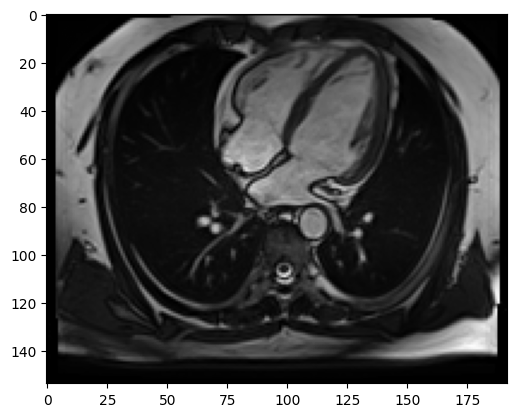

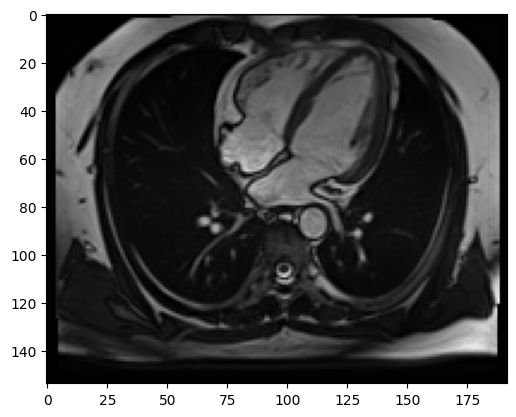

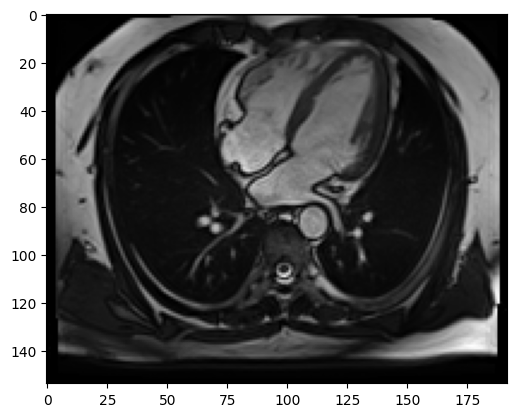

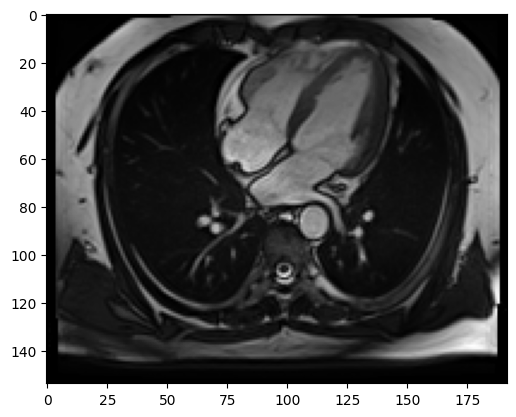

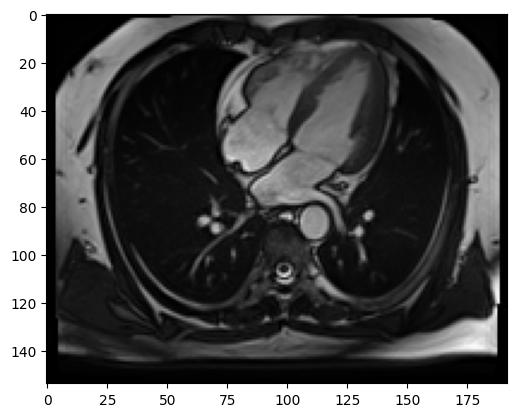

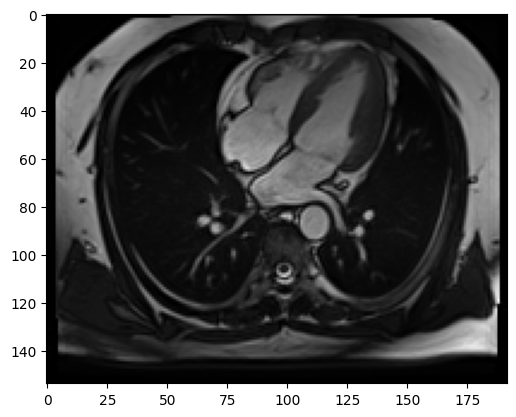

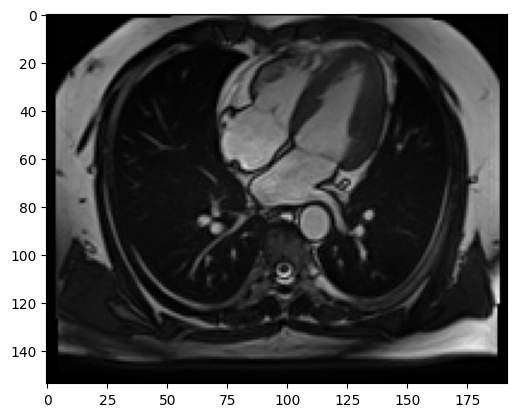

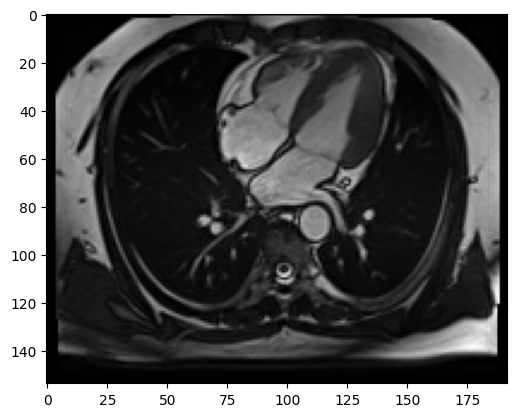

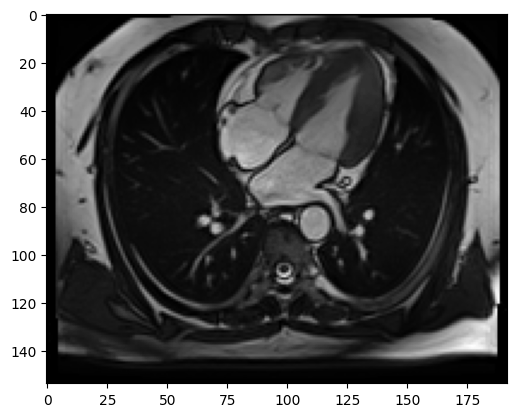

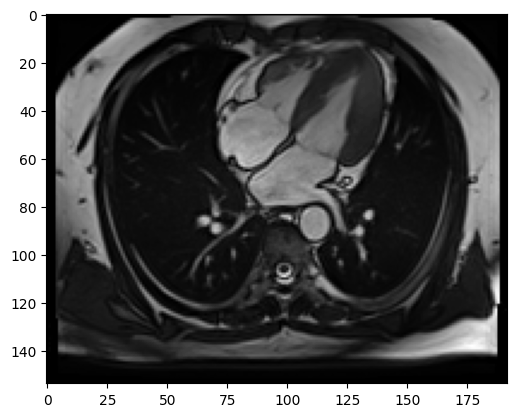

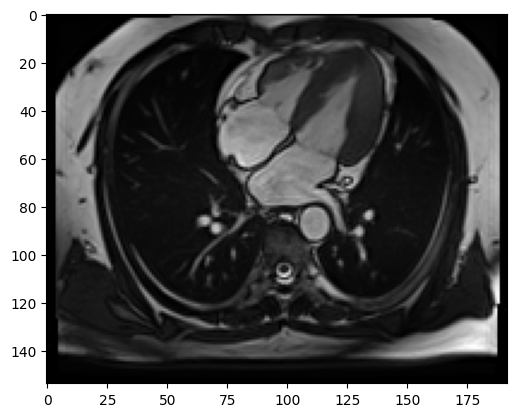

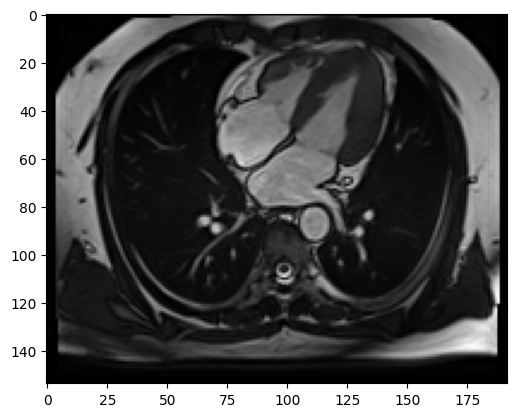

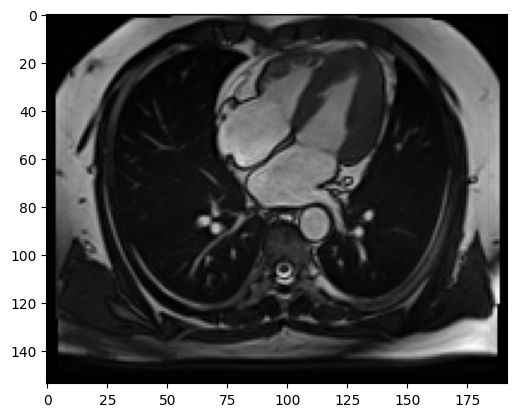

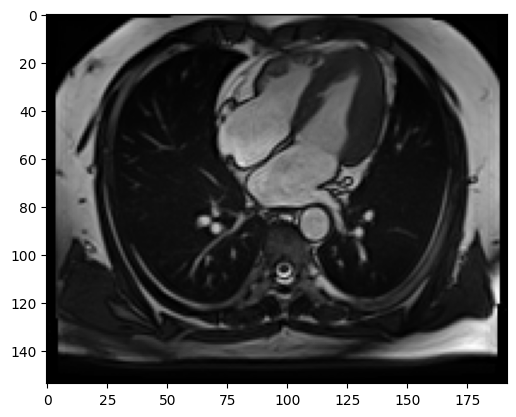

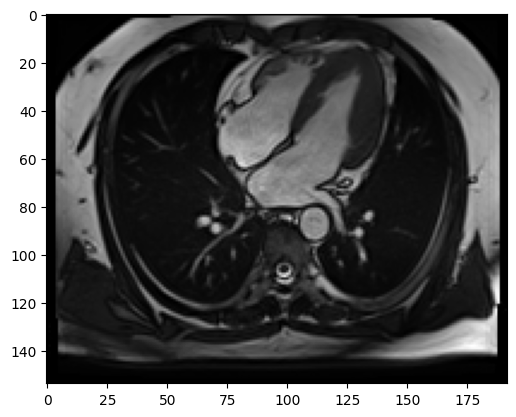

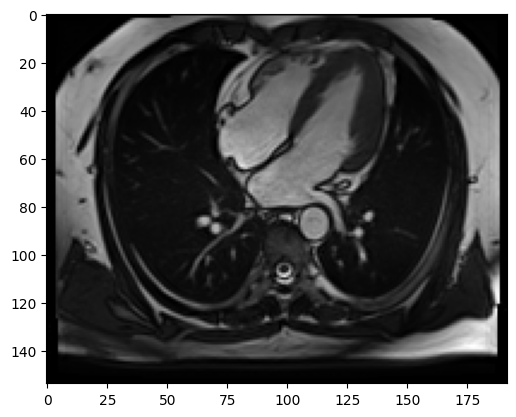

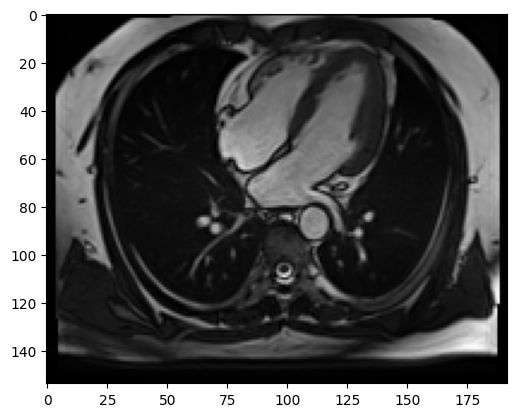

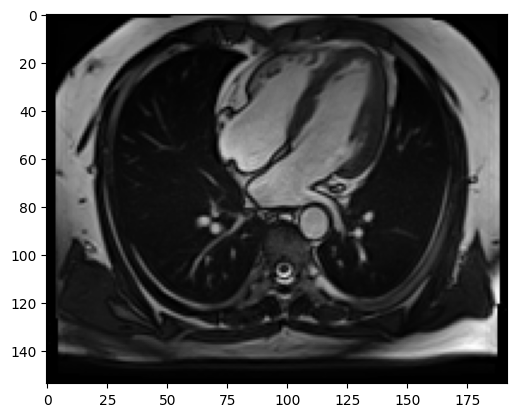

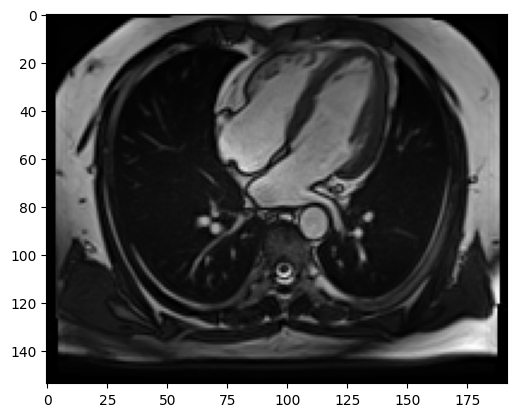

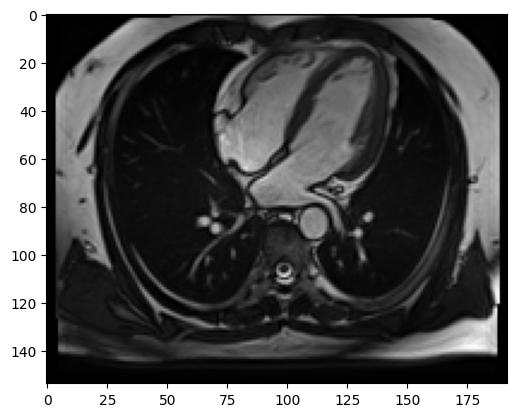

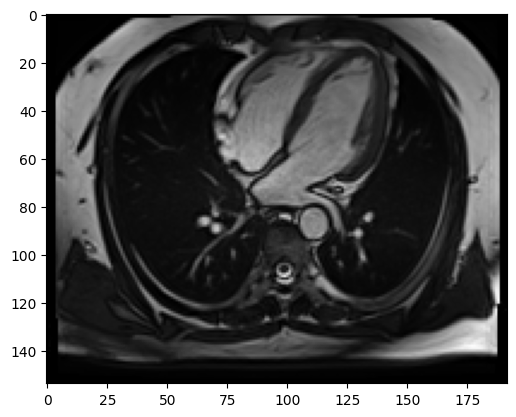

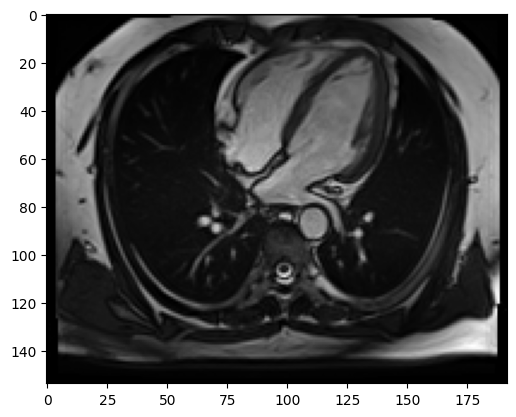

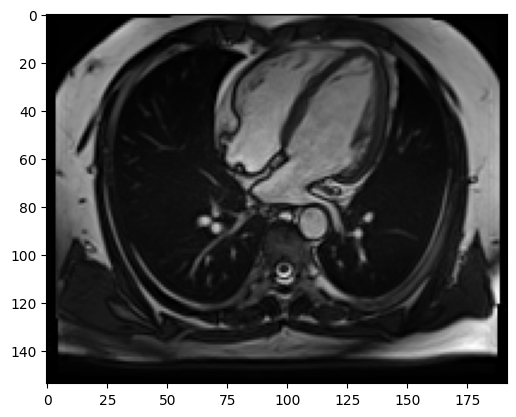

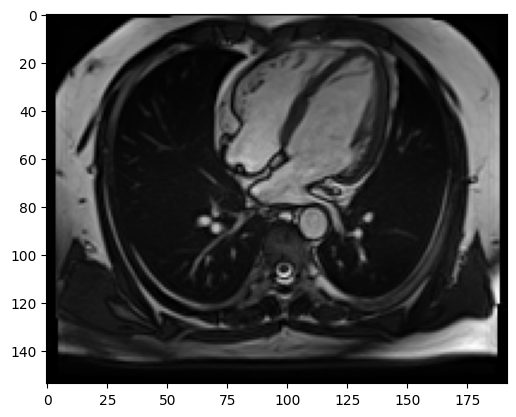

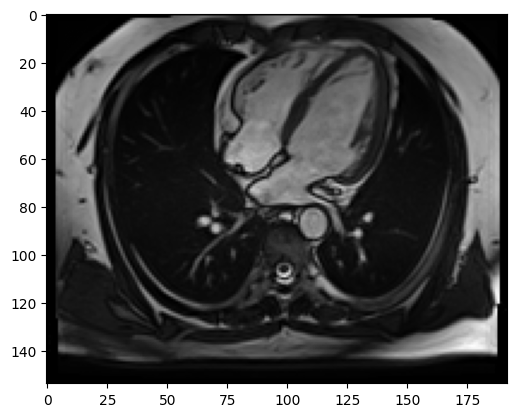

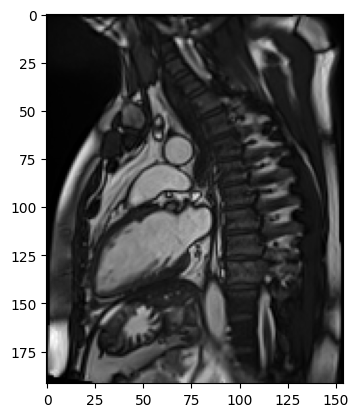

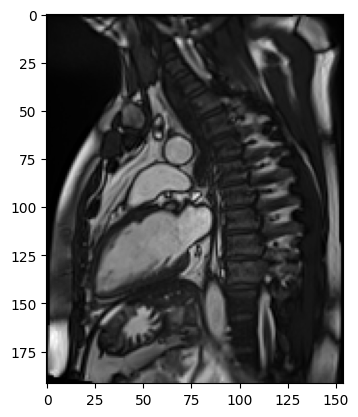

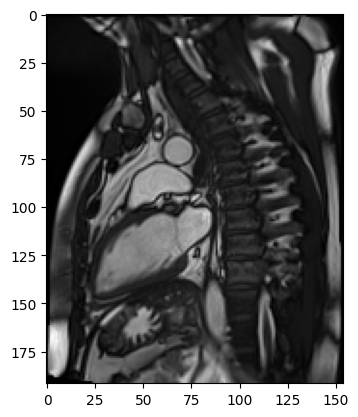

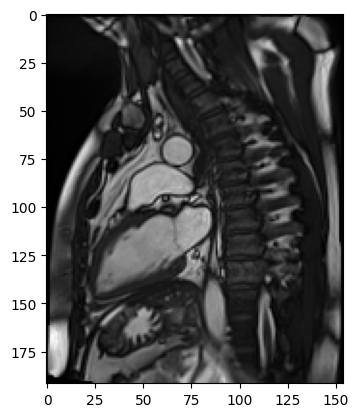

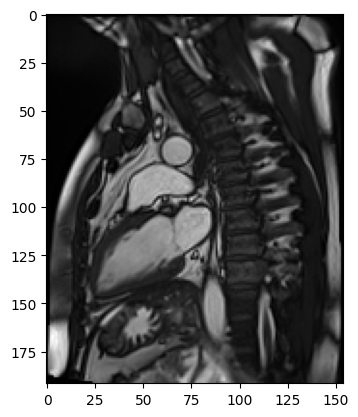

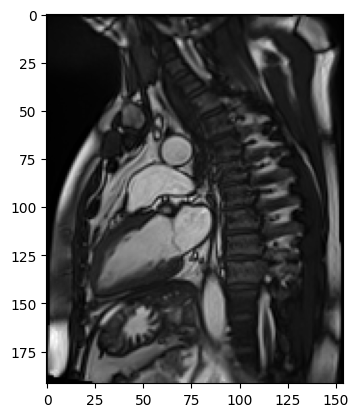

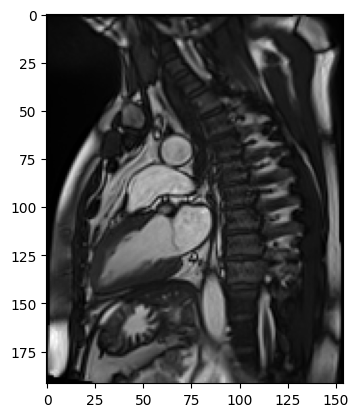

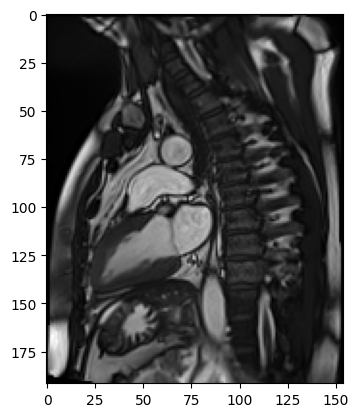

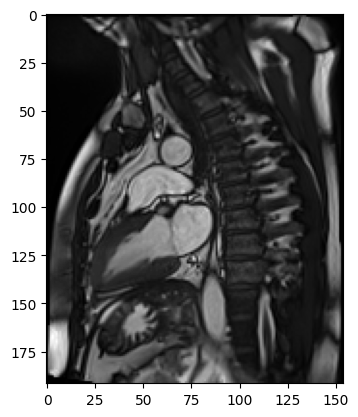

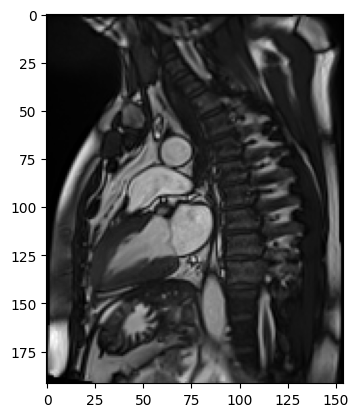

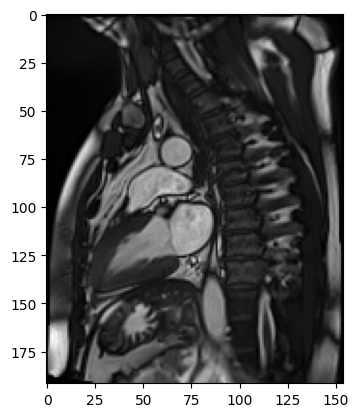

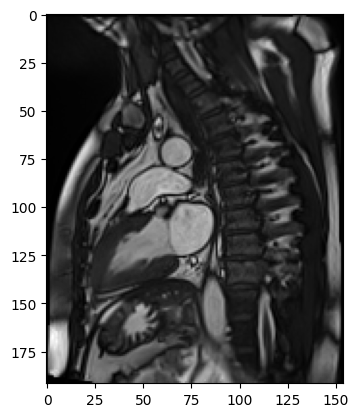

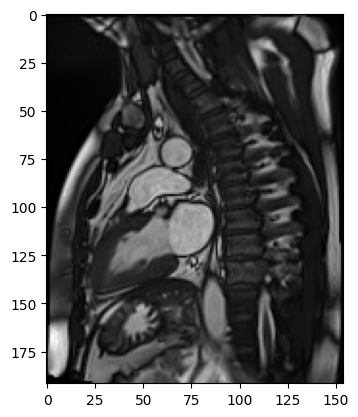

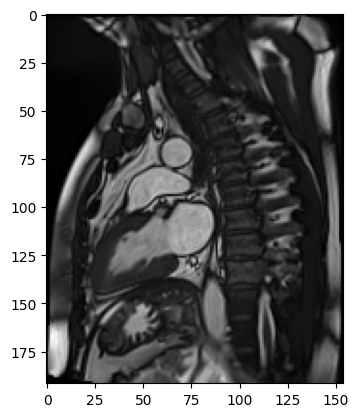

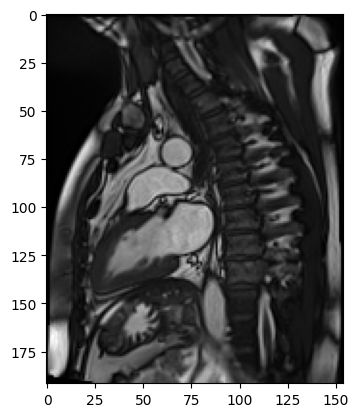

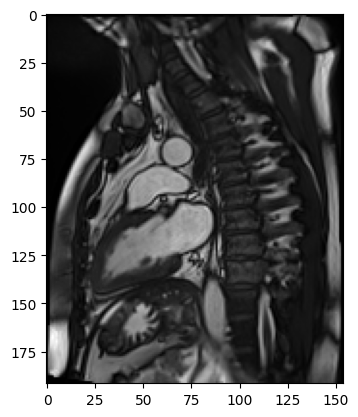

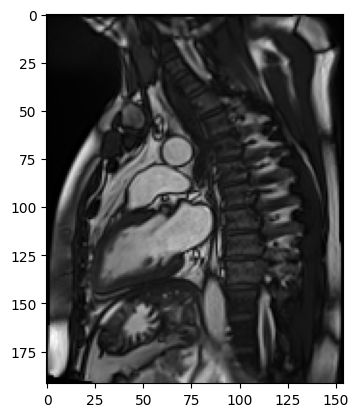

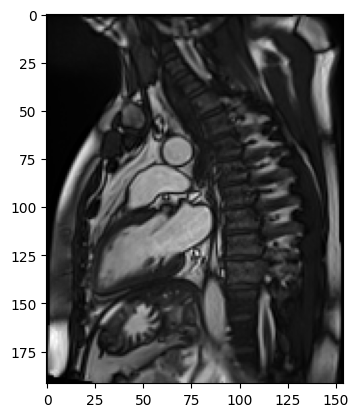

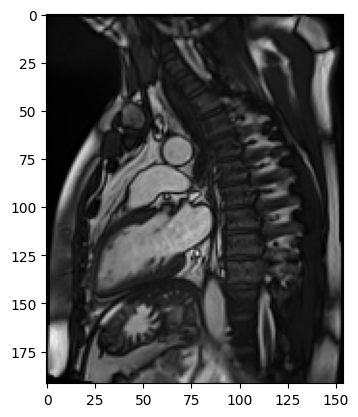

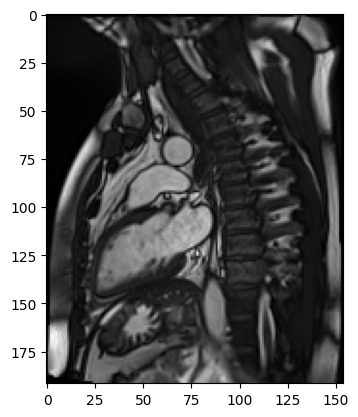

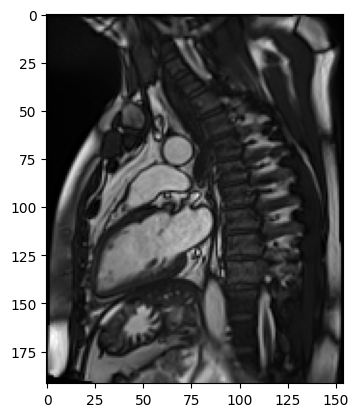

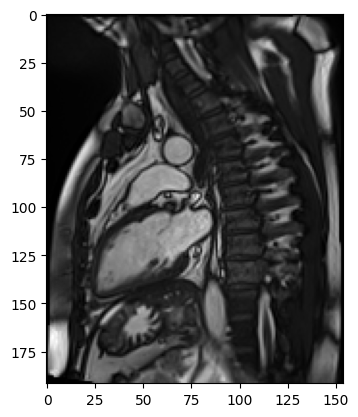

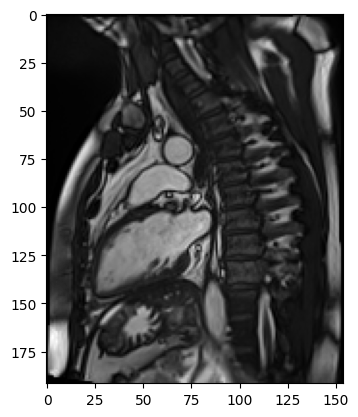

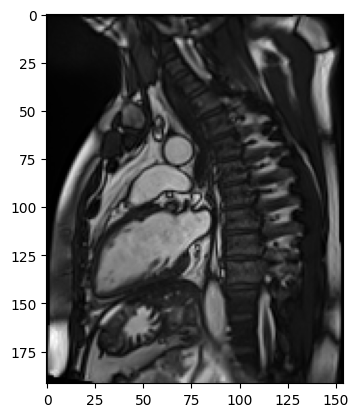

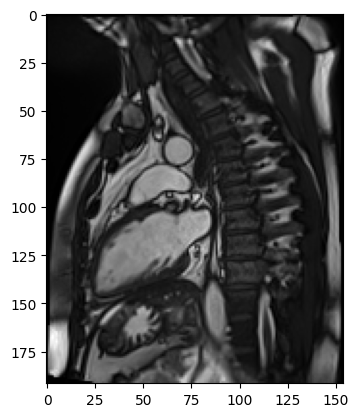

In [30]:
for sop, (d, p) in o.sop2depthandtime.items():
    img = o.get_img(d,p)
    plt.imshow(img, cmap='gray')
    plt.show()

In [6]:
def equivalent(a,b):
    #print(a.depthandtime2sop)
    #print(b.depthandtime2sop)
    print(a.depthandtime2sop == b.depthandtime2sop)